In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize as opt
from scipy.interpolate import CubicSpline
import plotly as pty
import time
import os

from fibers import *

from py_pol.jones_vector import Jones_vector
from py_pol.jones_matrix import Jones_matrix
from py_pol.stokes import Stokes
from py_pol.mueller import Mueller
from py_pol.utils import degrees

pi = np.pi
C_c = 299792458.0

In [2]:
import matplotlib as mpl
mpl.rcParams['font.family'] = "CMU Serif"
plt.rcParams['font.size'] = 18
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'CMU Serif'
mpl.rcParams['mathtext.it'] = 'CMU Serif:italic'
mpl.rcParams['mathtext.bf'] = 'CMU Serif:bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8.0
plt.rcParams['xtick.minor.size'] = 5.0
plt.rcParams['ytick.major.size'] = 8.0
plt.rcParams['ytick.minor.size'] = 5.0

# Figure 3

The following code generates the upper panel of Fig. 3.

In [3]:
_SellmeierCoeffs = {'SiO2': np.array(
                            [[[1.10127, -4.94251e-5, 5.27414e-7, -1.59700e-9, 1.75949e-12],
                              [-8.906e-2, 9.0873e-6, -6.53638e-8, 7.77072e-11, 6.84605e-14]],
                             [[1.78752e-5, 4.76391e-5, -4.49019e-7, 1.44546e-9, -1.57223e-12],
                              [2.97562e-1, -8.59578e-4, 6.59069e-6, -1.09482e-8, 7.85145e-13]],
                             [[7.93552e-1, -1.27815e-3, 1.84595e-5, -9.20275e-8, 1.48829e-10],
                              [9.34454, -70.9788e-3, 1.01968e-4, -5.07660e-7, 8.21348e-10]]]
                            ),
                    'GeO2': np.array(
                            [[0.80686642, 0.068972606],
                             [0.71815848, 0.15396605],
                             [0.85416831, 11.841931]]
                            ),
                    'F': np.array(
                         [[[-61.25, 0.2565],
                           [-23.0,0.101]],
                          [[73.9,-1.836],
                           [10.7,-0.005]],
                          [[233.5,-5.82],
                           [1090.5,-24.695]]]
                         )
                   }

In [4]:
def _calcN_Ge(w0, T0):
    """ Get the refractive index of germania at a given temperature and wavelength. """
    # We have Sellmeier coefficients and a formula for the thermo-optic coefficient
    # So we'll just add the two together
    wc = w0*1e6; Tc = T0 + 273.15 # Unit conversions
    n0 = np.sqrt(1 + np.sum(np.array([_SellmeierCoeffs['GeO2'][i][0]*wc**2/(wc**2 - _SellmeierCoeffs['GeO2'][i][1]**2) for i in range(len(_SellmeierCoeffs['GeO2']))])))
    Delta_n0 = 6.2153e-13/4*(Tc**4 - (24+273.15)**4) - 5.3387e-10/3*(Tc**3 - (24+273.15)**3) + 1.6654e-7/2*(Tc**2 - (24+273.15)**2)
    return n0 + Delta_n0
def _calcNs(w0, T0, m0, m1):
    """
    Calculates the refractive indices for the core and cladding silica-based material at
    wavelength w0 (m) and temperature T0 (°C). The molar fractions are m0 for the core and
    m1 for the cladding. If m is negative, dope the silica with fluorine; if positive,
    dope it with germania.
    Returns: n0 (refractive index of core), n1 (refractive index of cladding)
    """
    wc = w0*1e6; Tc = T0 + 273.15 # Unit conversions
    Tpows = np.array([Tc**i for i in [0,1,2,3,4]])
    nGe = _calcN_Ge(w0, T0)
    sc0 = np.zeros((3,2))
    sc1 = np.zeros((3,2))
    for i in range(3):
        for j in range(2):
            sc0[i][j] = np.dot(_SellmeierCoeffs['SiO2'][i][j], Tpows)
            sc1[i][j] = sc0[i][j] + (m1 < 0)*(_SellmeierCoeffs['F'][i][j][0]*np.abs(m1)**2 + _SellmeierCoeffs['F'][i][j][1]*np.abs(m1))
            sc0[i][j] = sc0[i][j] + (m0 < 0)*(_SellmeierCoeffs['F'][i][j][0]*np.abs(m0)**2 + _SellmeierCoeffs['F'][i][j][1]*np.abs(m0))
    n0 = np.sqrt(1 + np.sum(np.array([sc0[i][0]*wc**2/(wc**2 - sc0[i][1]**2) for i in range(len(sc0))])))
    n1 = np.sqrt(1 + np.sum(np.array([sc1[i][0]*wc**2/(wc**2 - sc1[i][1]**2) for i in range(len(sc1))])))
    if (m0 > 0):
        n0 = (1-m0)*n0 + m0*nGe
    if (m1 > 0):
        n1 = (1-m1)*n1 + m1*nGe
    return n0, n1

In [5]:
ws = np.arange(1200e-9, 1700e-9, 1e-9)
ns = np.array([_calcNs(ws[i], 20, 0, 0)[0] for i in range(len(ws))])

In [6]:
ws2 = np.arange(250e-9, 6000e-9, 25e-9)
ns2 = np.array([_calcNs(ws2[i], 20, 0, 0)[0] for i in range(len(ws2))])

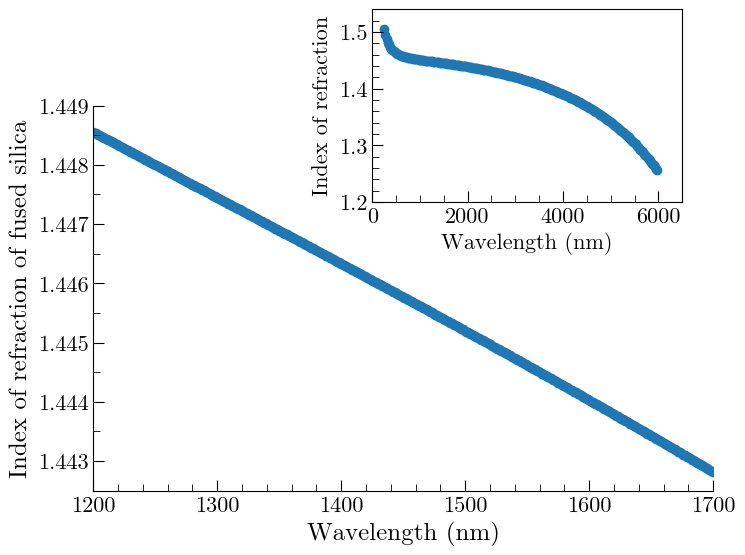

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(ws*1e9, ns)

ax.set_xlim(1200, 1700); ax.set_ylim(1.4425, 1.449)
ax.set_xlabel("Wavelength (nm)", fontsize=18); ax.set_ylabel("Index of refraction of fused silica", fontsize=18)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.001))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.0005))

axins1 = ax.inset_axes([0.45, 0.75, 0.50, 0.5])
axins1.scatter(ws2*1e9, ns2)
axins1.set_xlim(0,6500); axins1.set_ylim(1.2,1.54)
axins1.set_xlabel("Wavelength (nm)"); axins1.set_ylabel("Index of refraction")
axins1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2000))
axins1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(500))
axins1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
axins1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))

plt.show()

The lower panel is generated by code very similar to that of Fig. 4 below. The only difference is the specification $m_0 = 0.036$.

# Figure 4

In [8]:
# Initialize the fiber

w0 = 1625e-9      # Operating wavelength
T0 = 23           # Operating temperature
L0 = 1000         # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
epsilon = 1.005   # Core noncircularity
m0 = 0.03679      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 23         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

In [9]:
w0s = np.linspace(1100, 1400, 1001)*1e-9
vs = np.zeros(len(w0s))
for i in range(len(w0s)):
    f.w0 = w0s[i]
    vs[i] = f.v

closestToCutoffInd = np.argmin(np.abs(vs - 2.405))
w0s[closestToCutoffInd]*1e9

np.float64(1318.4)

In [10]:
f.w0 = 1550e-9
print(f.calcD_CD())

f.w0 = 1625e-9
print(f.calcD_CD())

12.310957350133876
16.147874291955702


In [11]:
f.w0 = 1310e-9
print(f.calcNGEff())

f.w0 = 1550e-9
print(f.calcNGEff())

1.4676362040785373
1.4680070188303034


In [12]:
f.T0 = 23
f.Tref = 23

w0s = np.linspace(1200, 1650, 1001)*1e-9
dcds = np.zeros(len(w0s))
for i in range(len(w0s)):
    f.w0 = w0s[i]
    dcds[i] = f.calcD_CD()

closestToZeroInd = np.argmin(np.abs(dcds))
zeroDispersionSlope = (dcds[closestToZeroInd] - dcds[closestToZeroInd - 1])/(w0s[closestToZeroInd] - w0s[closestToZeroInd - 1])/1e9
print("The zero dispersion slope is {:.4f} ps/(nm^2 km) at about {:.2f} nm.".format(zeroDispersionSlope, w0s[closestToZeroInd]*1e9))

def testFunc(w0, S0, lambda0): return (S0/4)*(w0 - lambda0**4/w0**3)
popt, pcov = opt.curve_fit(testFunc, w0s, dcds, p0 = np.array([0.073e9, 1350e-9]))
print("Fitted values are {:.4f} ps/(nm^2 km) at about {:.2f} nm.".format(popt[0]/1e9, popt[1]*1e9))

The zero dispersion slope is 0.0735 ps/(nm^2 km) at about 1350.30 nm.
Fitted values are 0.0749 ps/(nm^2 km) at about 1349.62 nm.


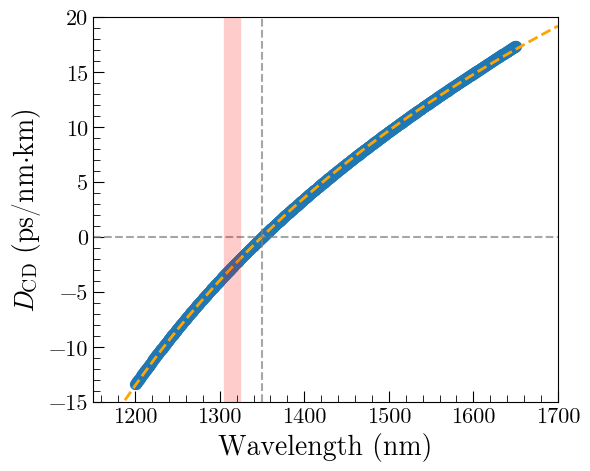

In [13]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(w0s*1e9, dcds, s=50)
fitPlotW0s = np.linspace(1150, 1700, 101)*1e-9
ax.plot(fitPlotW0s*1e9, testFunc(fitPlotW0s, popt[0], popt[1]), color='orange', linestyle='dashed', lw=2)
ax.axhline(y = 0, color='gray', linestyle='dashed', alpha=0.7); ax.axvline(x = popt[1]*1e9, color='gray', linestyle='dashed', alpha=0.7)
ax.axvline(x = 1314, color='red', alpha=0.2, linewidth=10*1.25)

ax.set_xlim(1150, 1700); ax.set_ylim(-15,20)
ax.set_xlabel("Wavelength (nm)", fontsize=20); ax.set_ylabel("$D_\\text{CD}$ (ps/nm$ \\cdot $km)", fontsize=20)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

plt.show()

# Figure 5

The code below was used to generate Fig. 5. Note that this code works with a modified version of ``plotly`` as described in the GitHub readme.

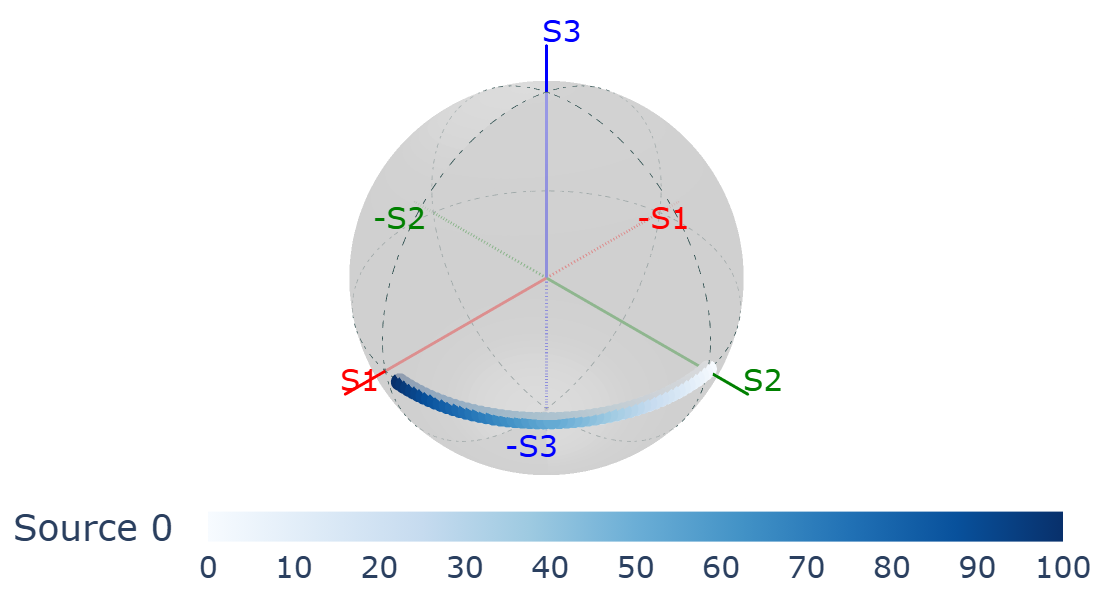

In [14]:
w0 = 1400e-9
T0 = 20
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.000
m0 = 0.0347
m1 = 0.000
Tref = 20

nPaddles = 1
rps = np.array([0.056/2])
tfs = np.array([0])
Ns = np.array([6])
gapLs = np.array([0.02])

paddleAngles = np.linspace(1e-6,100,51)*pi/180

J0arr = np.zeros((len(paddleAngles), 2, 2), dtype=np.complex128)
f = FiberPaddleSet(w0, T0, r0, r1, epsilon, m0, m1, Tref, nPaddles, rps, np.array([paddleAngles[0]]), tfs, Ns, gapLs)

for i in range(len(paddleAngles)):
    f.angles[0] = paddleAngles[i]
    J0arr[i,:,:] = f.J0

Ei = Jones_vector("Source 0"); Ei.linear_light(azimuth = -45*degrees, amplitude=1)
J0 = Jones_matrix("J0"); J0.from_matrix(J0arr)
E0 = J0 * Ei; #E1 = J1 * Ei
S0 = Stokes("Source 0"); S0.from_Jones(E0)

fig0 = pty.subplots.make_subplots(rows=1, cols=1, specs=[[{'type':'surface'}]])
S0.draw_poincare(fig=fig0, draw_axes=True, colormap='blues', param=paddleAngles*180/pi, show_fig=False)
fig0.show()

# Figure 6

This figure is a comparison to another paper, which plots its data s a functon of $V$. To get $V$ as a function of the BIFROST input, wavelength, I will generate a test fiber length with the desired parameters and use that to numerically obtain $V(\lambda)$.

In [3]:
def e2(ecc): return np.sqrt(1/(1-ecc**2))

w0 = 1550e-9      # Operating wavelength
T0 = 25           # Operating temperature
L0 = 1           # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = e2(ecc)
m0 = 0.03683      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 20         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

w0n = 100
w0s = np.linspace(1300, 3400, w0n+1)*1e-9
Vs = np.zeros(w0n+1)
for i in range(w0n+1):
    f.w0 = w0s[i]
    Vs[i] = f.v

vFunc = CubicSpline(w0s, Vs)

Now we generate the upper right panel of Fig 6. The parameters were chosen to match the ones specified in the comparison paper.

In [4]:
def e2(ecc): return np.sqrt(1/(1-ecc**2))

w0 = 1550e-9      # Operating wavelength
T0 = 25           # Operating temperature
L0 = 1            # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = e2(ecc)
m0 = 0.03683      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 25         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

eccs = np.array([0.197, 0.275, 0.332, 0.378, 0.417])
Vsarr = np.linspace(1.0, 2.4, 71)
BCNCs = np.zeros((len(eccs),len(Vsarr)))
BATSs = np.zeros((len(eccs),len(Vsarr)))
for i in range(len(eccs)):
    f.epsilon = e2(eccs[i])
    for k in range(len(Vsarr)):
        f.w0 = opt.fsolve(lambda x: vFunc(x) - Vsarr[k], np.array([2000e-9]))[0]
        BCNCs[i][k] = f.B_CNC
        BATSs[i][k] = f.B_ATS

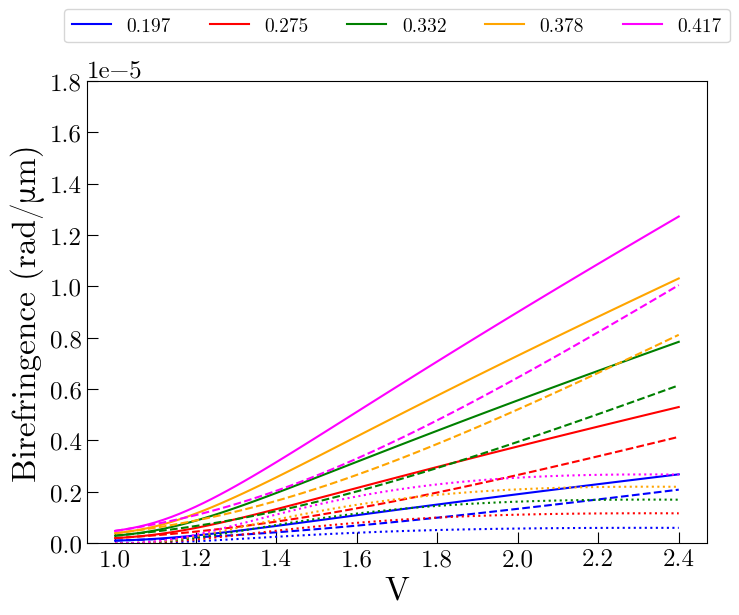

In [5]:
cols = ['blue', 'red', 'green', 'orange', 'magenta']
fig, ax = plt.subplots(figsize=(8,6))
for j in range(len(eccs)):
    ax.plot(Vsarr, BCNCs[j]/1e6, ls=':', c=cols[j])
    ax.plot(Vsarr, BATSs[j]/1e6, ls='--', c=cols[j])
    ax.plot(Vsarr, BCNCs[j]/1e6 + BATSs[j]/1e6, label=str(eccs[j]), ls='-', c=cols[j])
ax.set_xlabel("V", fontsize=24)
ax.set_ylabel("Birefringence (rad/μm)", fontsize=24)
ax.set_ylim(0,18/1e6)
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.12), ncol = 5, fontsize=14)
plt.show()

Now let's generate the lower right panel of Fig 6. The cells below are the code used to generate the figure. It takes a while to run.

In [14]:
Ltot = 80e3       # Total length of fiber

w0 = opt.fsolve(lambda x: vFunc(x) - 1.8, np.array([2000e-9]))[0]
T0 = 25           # Operating temperature
m0 = 0.03683      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 25         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

N0 = 800           # Number of hinges

segmentDict = {'epsilon': e2(0.197), 'm0': m0, 'm1': m1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0, 'L0': {'scale': 10, 'dist': 'normal'}}
hingeDict = {}

nExp = 1000
eccs = np.array([0.24, 0.275, 0.332, 0.398])
dgds = np.zeros((len(eccs),nExp))
t0 = time.time()
for j in range(len(eccs)):
    segmentDict['epsilon'] = e2(eccs[j])
    print(eccs[j])
    for i in range(nExp):
        f = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 1, hingeStart = False, hingeEnd = False, arbRotStart = False)
        dgds[j][i] = f.calcDGD(dw0=0.0001e-9)*1e12
        if ((i+1) % 10 == 0):
            print(i+1, end= " ")
    print(" ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

0.24
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000  
0.275
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000  
0.332
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 

In [15]:
np.savetxt(os.path.join(os.getcwd(), "Figure6_Data.csv"), dgds, fmt='%1.8f', delimiter=',')

Let's load the data for the figure.

In [6]:
dgds = np.loadtxt(os.path.join(os.getcwd(), "Figure6_Data.csv"), delimiter=',', dtype=float)

In [7]:
Ltot = 80e3
eccs = np.array([0.24, 0.275, 0.332, 0.398])

E[t] = 13.489 ps
This corresponds to D_PMD = 1.508 ps/sqrt(km).
 
E[t] = 17.941 ps
This corresponds to D_PMD = 2.006 ps/sqrt(km).
 
E[t] = 26.065 ps
This corresponds to D_PMD = 2.914 ps/sqrt(km).
 
E[t] = 37.895 ps
This corresponds to D_PMD = 4.237 ps/sqrt(km).
 


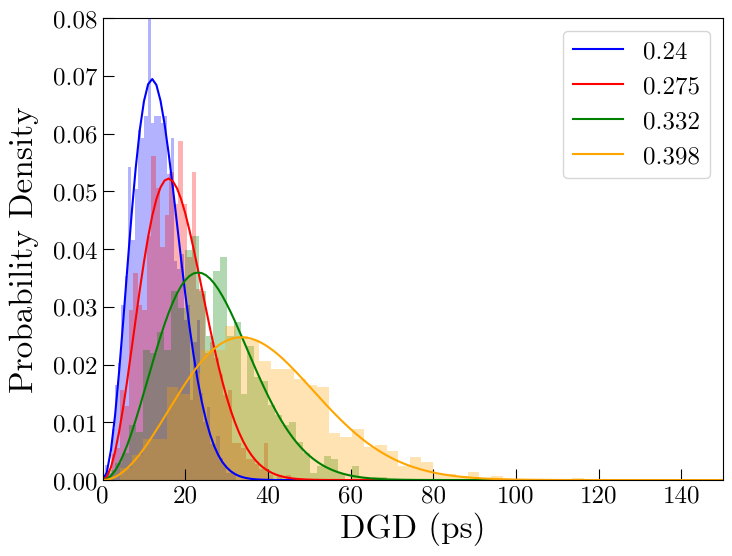

In [8]:
cols = ['blue', 'red', 'green', 'orange']

def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(eccs)):
    ns, bins = np.histogram(dgds[i], bins=40)
    x2 = np.linspace(0, 150, 151)
    xs = (bins[1:] + bins[:-1])/2
    ys = ns/np.sum(ns * (bins[1]-bins[0]))
    popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
    print("E[t] = {:.3f} ps".format(popt[0]))
    print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(Ltot/1e3)))
    print(" ")
    ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, color=cols[i], alpha=0.3)
    ax.plot(x2, MB(x2, popt[0]), c=cols[i], label=str(round(eccs[i],3))) # linestyle='dotted', linewidth=2, 

ax.set_xlabel("DGD (ps)", fontsize=24)
ax.set_ylabel("Probability Density", fontsize=24, labelpad=10.0)
ax.set_ylim(0,0.08); ax.set_xlim(0,150)
ax.legend()
plt.show()

# Figure 8

Some utility functions for this calculation.

In [3]:
def azimuthAngleConvert(vec, phi):
    if (vec[0] > 0):
        if (vec[1] >= 0):
            return np.arccos(vec[0]/np.sin(phi))
        else:
            return np.arcsin(vec[1]/np.sin(phi))
    else:
        if (vec[1] >= 0):
            return np.arccos(vec[0]/np.sin(phi))
        else:
            return -np.pi-np.arcsin(vec[1]/np.sin(phi))

def LeviCivita3(i,j,k):
    if ([i,j,k] == [1,2,3] or [i,j,k] == [2,3,1] or [i,j,k] == [3,1,2]):
        return 1
    elif ([i,j,k] == [2,1,3] or [i,j,k] == [1,3,2] or [i,j,k] == [3,2,1]):
        return -1
    else:
        return 0

In [4]:
def getAngles(Jbase, rotAxisRef = None):
    # Get the Mueller matrix for the fiber
    J0 = Jones_matrix("J0"); J0.from_matrix(Jbase)
    M0 = Mueller("M0"); M0.from_Jones(J0)
    M0arr = M0.get_list()[1:,1:]
    # Get the eigenvalues and eigenvectors
    vals, vecs = np.linalg.eig(M0arr)
    rotAngle = 0
    rotAxis = np.zeros(3)
    # If no reference passed in...
    if isinstance(rotAxisRef, type(None)):
        # Rotation angle
        rotAngle = np.sort(np.angle(vals))[-1]
        # Rotation axis
        rotAxis = (1/2*np.sin(rotAngle))*np.array([M0arr[2,1]-M0arr[1,2], M0arr[0,2]-M0arr[2,0], M0arr[1,0]-M0arr[0,1]])
        rotAxis = rotAxis/np.linalg.norm(rotAxis)
    else:
        # Try to match the reference passed in
        # Quick way to get a new axis up to a sign
        rotAxis = np.real(vecs[:,[i for i in range(3) if np.all(np.real(vecs[:,i])==vecs[:,i])][0]])
        # Flip if needed to ensure continuity with the reference
        if (np.dot(rotAxis, rotAxisRef) < 0):
            rotAxis = -rotAxis
        rotAxis = rotAxis/np.linalg.norm(rotAxis)
        # Rotation angle
        rotAngle = np.sort(np.angle(vals))[-1]
        # Reconstruct the Mueller matrix to verify
        Mcheck = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                Mcheck[i][j] = np.cos(rotAngle)*(i==j) + (1-np.cos(rotAngle))*rotAxis[i]*rotAxis[j] - np.sin(rotAngle)*np.sum([LeviCivita3(i+1,j+1,k+1)*rotAxis[k] for k in range(3)])
        if not (np.allclose(M0arr, Mcheck)):
            rotAngle = -rotAngle
    phi1 = np.arccos(rotAxis[2])
    phi2 = azimuthAngleConvert(rotAxis, phi1)
    return rotAngle, phi1, phi2, rotAxis[0], rotAxis[1], rotAxis[2]

In [5]:
def getMuellerAxisAngle(rotAngle, rotAxis, dim4 = True):
    M0 = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            M0[i][j] = np.cos(rotAngle)*(i==j) + (1-np.cos(rotAngle))*rotAxis[i]*rotAxis[j] - np.sin(rotAngle)*np.sum([LeviCivita3(i+1,j+1,k+1)*rotAxis[k] for k in range(3)])
    if dim4:
        M1 = np.eye(4); M1[1:, 1:] = M0; M0 = M1.copy()
    return M0

Simulate a fiber. Note that the results vary strongly with DGD, so check that the DGD is near-ish to the ensemble average.

In [8]:
# Parameters
f0 = 193.350e12
w0s = C_c/f0 + np.array([0, 0.2e-9, 0.8e-9, 2.0e-9, 5.0e-9])

Ltot = 26e3
w0 = 1550e-9
T0 = 20
r0 = 4.1e-6
r1 = 125e-6/2
m0 = 0.036
m1 = 0.000
Tref = 20

N0 = 6

nPaddles = 3
tfs = np.array([0, 0, 0])
Ns = np.array([2, 4, 2])

Lr = 5

# Code
segmentDict = {'m0': m0, 'm1': m1, 'r0': r0, 'r1': r1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0, 'L0': {'scale': Ltot/N0/10, 'dist': 'normal'}}
hingeDict = {'nPaddles': nPaddles, 'Ns': Ns, 'tfs': tfs, 'Tref': np.array([Tref]*(N0-1)), 'T0': np.array([T0]*(N0-1)),
             'rps': {'mean': 1, 'scale': 0.1, 'dist': 'normal'},
             'gapLs': {'mean': 1, 'scale': 0.1, 'dist': 'normal'},
             'angles': {'mean': 180, 'scale': 180, 'dist': 'uniform'}}

In [101]:
f = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 0, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})

f.w0 = w0s[0]
print("DGD: {:.3f} ps".format(f.calcDGD()*1e12))

DGD: 0.205 ps


This is near the ensemble average, so let's perform the simulations.

In [9]:
# 0° = H light
Ei = Stokes("Source 0"); Ei.linear_light(azimuth = 0*degrees, amplitude=1); Ei0 = Ei.get_list()
Ef = np.zeros((nExp, len(w0s), 4))
res = np.ones((nExp, len(w0s)))

In [110]:
t0 = time.time()
for j in range(nExp):
    # Set the temperatures randomly
    f.hingeDict['T0'] = np.random.random(5)*4+18
    # Get the PTF at lambdaQ
    f.w0 = w0s[0]
    anglesQ = getAngles(f.J0)
    rotAxisPrev = anglesQ[3:]
    MQ = getMuellerAxisAngle(anglesQ[0], anglesQ[3:])
    Ef[j,0,:] = np.transpose(Ei0); res[j,0] = 0
    # Now vary the wavelength, get the PTF at lambdaR, and do the compensation
    for i in range(1,len(w0s)):
        # Get the PTF at lambdaR
        f.w0 = w0s[i]
        anglesR = getAngles(f.J0, rotAxisRef = rotAxisPrev)
        rotAxisPrev = anglesR[3:]
        MR = getMuellerAxisAngle(anglesR[0], anglesR[3:])
        # Now do the transmission and compensation stepsb
        Ef0 = np.matmul(np.linalg.inv(MR), np.matmul(MQ, Ei0))
        Ef[j,i,:] = np.transpose(Ef0)
        res[j,i] = np.arccos(np.dot(np.transpose(Ei0[1:]), Ef0[1:]))
    print(j, end=" ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249  
Completed in 26.78 minutes.


The cells above were used to generate the data for Figure 8. The last cell takes some time to run (around 30 minutes), so here we reload the data, which was previously saved with commands similar to the following:

In [111]:
for i in range(len(Ef[0])):
    np.savetxt(os.path.join(os.getcwd(), "Figure8_Data", 'CompensationVectors'+str(i)+'.csv'), Ef[:,i], fmt='%1.8f', delimiter=',')

In [112]:
np.savetxt(os.path.join(os.getcwd(), "Figure8_Data", 'CompensationAngle.csv'), res, fmt='%1.8f', delimiter=',')

Let's reload the data. Before doing so, you'll need to run a couple fo the cells above, but you *don't* need to run the one that'll take a long time.

In [10]:
Ef = np.zeros((nExp, len(w0s), 4))
for i in range(len(Ef[0])):
    Ef[:,i] = np.loadtxt(os.path.join(os.getcwd(), "Figure8_Data", 'CompensationVectors'+str(i)+'.csv'), delimiter=',', dtype=float)

In [11]:
fids = np.zeros((nExp, len(w0s)))

for j in range(nExp):
    for i in range(1,len(w0s)):
        fids[j,i] = np.dot(np.transpose(Ei0[1:]), Ef[j,i,1:])

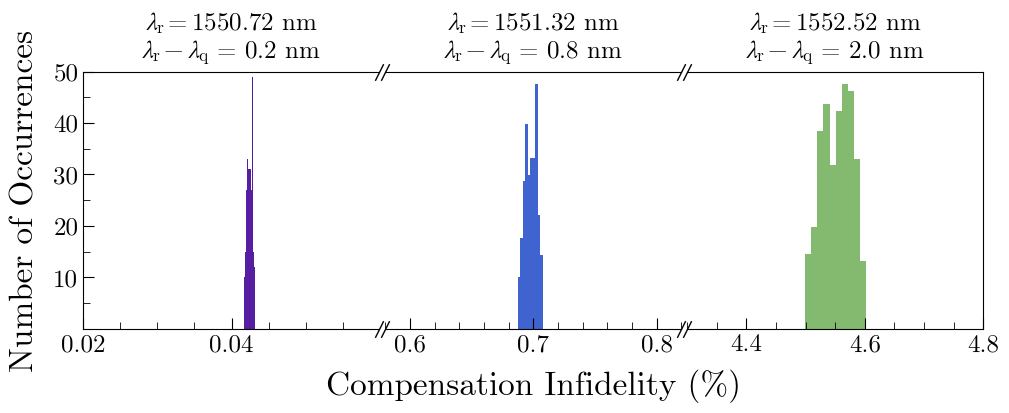

In [13]:
colors1 = np.array(['#e54545','#ffbb33','#60bf60','#45a3e6','#6262d9','#b8cbd9','#1378bf'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.hist((1-fids[:,1])*100, label="{:.2f} nm".format(w0s[1]*1e9), color='#571EA2')
ax2.hist((1-fids[:,2])*100, label="{:.2f} nm".format(w0s[2]*1e9), color='#3F63CF')
ax3.hist((1-fids[:,3])*100, label="{:.2f} nm".format(w0s[3]*1e9), color='#83BA70')

ax1.set_xlim(0.02, 0.0599)
ax2.set_xlim(0.58, 0.82)
ax3.set_xlim(4.3, 4.8)
ax1.set_ylim(0.001, 50)

ax2.spines.left.set_visible(False); ax3.spines.left.set_visible(False)
ax1.spines.right.set_visible(False); ax2.spines.right.set_visible(False)
ax2.set_yticks([]); ax3.set_yticks([])

d = 2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [1, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
ax2.plot([1, 1], [1, 0], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 0], [1, 0], transform=ax3.transAxes, **kwargs)

ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
ax3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))

ax1.set_title("$\\lambda_\\text{{r}} = ${:.2f} nm\n$\\lambda_\\text{{r}} - \\lambda_\\text{{q}}$ = {:.1f} nm".format(w0s[1]*1e9, (w0s[1]-w0s[0])*1e9), fontsize=18, pad=10.0)
ax2.set_title("$\\lambda_\\text{{r}} = ${:.2f} nm\n$\\lambda_\\text{{r}} - \\lambda_\\text{{q}}$ = {:.1f} nm".format(w0s[2]*1e9, (w0s[2]-w0s[0])*1e9), fontsize=18, pad=10.0)
ax3.set_title("$\\lambda_\\text{{r}} = ${:.2f} nm\n$\\lambda_\\text{{r}} - \\lambda_\\text{{q}}$ = {:.1f} nm".format(w0s[3]*1e9, (w0s[3]-w0s[0])*1e9), fontsize=18, pad=10.0)

fig.tight_layout()
fig.subplots_adjust(wspace=0.02)  # adjust space between Axes

ax1.set_ylabel("Number of Occurrences", labelpad=10.0, fontsize=24)
ax2.set_xlabel("Compensation Infidelity (%)", labelpad=10.0, fontsize=24)

plt.show()